In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

from wongutils.grmhd.athenak import AthenaKSnapshot

from wongutils.geometry import coordinates, metrics
from wongutils.grmhd import utilities

In [2]:
fname = 'torus.mhd_w_bcc.01000.bin'
snapshot = AthenaKSnapshot(fname)

100%|██████████| 456/456 [00:09<00:00, 47.18it/s]


# directly plotting GRMHD snapshot data at arbitrary locations

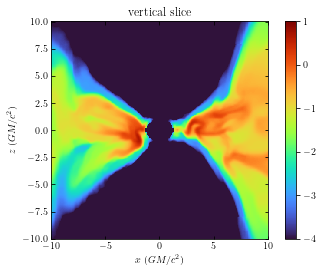

In [3]:
plim = 10
res = 501

xs = np.linspace(-plim, plim, res)
ys = np.zeros((1))
zs = np.linspace(-plim, plim, res)
X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')

prims = snapshot.get_primitives_at(Y, X, Z)
# 8 -> density, internal energy, vx, vy, vz, bx, by, bz

ax1 = plt.subplot(1, 1, 1)

im1 = ax1.pcolormesh(X[:, 0, :], Z[:, 0, :], np.log10(prims[:, 0, :, 0]), vmin=-4, vmax=1, cmap='turbo')
plt.colorbar(im1)

ax1.set_aspect('equal')
ax1.tick_params(direction='in', which='both', top=True, right=True, color='k')
ax1.set_xlabel(r'$x\ (GM/c^2)$')
ax1.set_ylabel(r'$z\ (GM/c^2)$')
ax1.set_title('vertical slice') ;

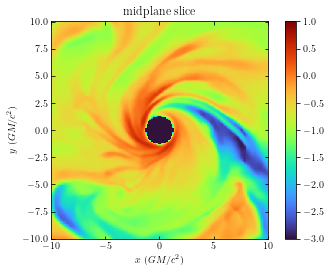

In [4]:
plim = 10
res = 501

xs = np.linspace(-plim, plim, res)
ys = np.linspace(-plim, plim, res)
zs = np.zeros((1))
X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')

prims = snapshot.get_primitives_at(X, Y, Z)

ax1 = plt.subplot(1, 1, 1)

im1 = ax1.pcolormesh(X[:, :, 0], Y[:, :, 0], np.log10(prims[:, :, 0, 0]), vmin=-3, vmax=1, cmap='turbo')
plt.colorbar(im1)

ax1.set_aspect('equal')
ax1.tick_params(direction='in', which='both', top=True, right=True, color='k')
ax1.set_xlabel(r'$x\ (GM/c^2)$')
ax1.set_ylabel(r'$y\ (GM/c^2)$')
ax1.set_title('midplane slice') ;

# utilities for converting between coordinates

In [5]:
bhspin = snapshot.header['coord']['a']

# define grid in, e.g., spherical coordinates
r_ks = np.linspace(1., 20, 101)
h_ks = np.linspace(0., np.pi, 101)[1:-1]
p_ks = np.array([0.])

# get 3d grid
R_ks, H_ks, P_ks = np.meshgrid(r_ks, h_ks, p_ks, indexing='ij')

# get Cartesian coordinates from KS coordinates
X_cks, Y_cks, Z_cks = coordinates.x_cks_from_ks(dict(bhspin=bhspin), R_ks, H_ks, P_ks)

# sample variables at those points (regular in spherical KS)
prims_cks = snapshot.get_primitives_at(X_cks, Y_cks, Z_cks)
rho = prims_cks[..., 0]

In [6]:
# get metrics (in CKS)
gcon_cks = metrics.get_gcon_cks_from_cks(bhspin, X_cks, Y_cks, Z_cks)
gcov_cks = metrics.get_gcov_cks_from_cks(bhspin, X_cks, Y_cks, Z_cks)

# get four-vector quantities (in CKS)
ucon_cks, ucov_cks = utilities.U123_to_ucon(prims_cks[..., 2], prims_cks[..., 3], prims_cks[..., 4], gcon_cks, gcov_cks)
bcon_cks, bcov_cks = utilities.B123_to_bcon(prims_cks[..., 5], prims_cks[..., 6], prims_cks[..., 7], ucon_cks, gcov_cks)

/var/folders/p_/h58yy99x6lj86pm4mpvkgc3m0000gq/T/ipykernel_43678/3642421627.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1 = ax1.pcolormesh(X_plt, Z_plt, np.log10(sigma[:, :, 0]), vmin=-3, vmax=3, cmap='RdBu')


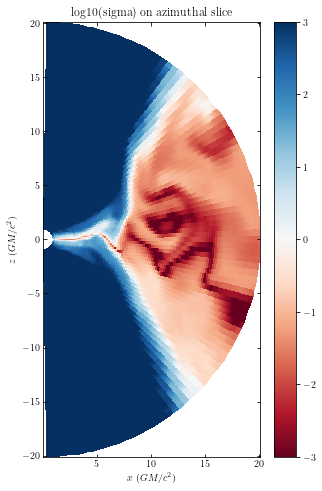

In [7]:
# compute magnetization and plot
bsq = np.einsum('...i,...i->...', bcon_cks, bcov_cks)  # should be 1 everywhere
sigma = bsq / rho

fig = plt.figure(figsize=(5, 8), facecolor='w')
ax1 = plt.subplot(1, 1, 1)

X_plt = (R_ks * np.sin(H_ks))[:, :, 0]
Z_plt = (R_ks * np.cos(H_ks))[:, :, 0]

im1 = ax1.pcolormesh(X_plt, Z_plt, np.log10(sigma[:, :, 0]), vmin=-3, vmax=3, cmap='RdBu')
ax1.set_aspect('equal')
plt.colorbar(im1)

ax1.tick_params(direction='in', which='both', top=True, right=True, color='k')
ax1.set_xlabel(r'$x\ (GM/c^2)$')
ax1.set_ylabel(r'$z\ (GM/c^2)$')
ax1.set_title('log10(sigma) on azimuthal slice') ;

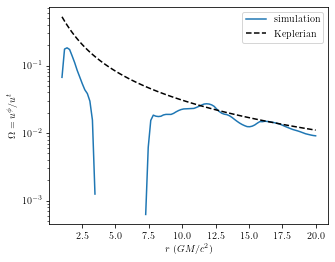

In [8]:
# convert to ks components
dxdX_ks_cks = coordinates.get_dxdX_ks_cks_from_cks(bhspin, X_cks, Y_cks, Z_cks)
ucon_ks = np.einsum('...ij,...j->...i', dxdX_ks_cks, ucon_cks)
bcon_ks = np.einsum('...ij,...j->...i', dxdX_ks_cks, bcon_cks)

# construct Omega = u^phi / u^t and plot in midplane
Omega = ucon_ks[..., 3] / ucon_ks[..., 0]

fig = plt.figure(figsize=(5, 4), facecolor='w')
ax1 = plt.subplot(1, 1, 1)
Omega_midplane = Omega[:, Omega.shape[1]//2, 0]
Omega_midplane[Omega_midplane <= 0] = np.nan
ax1.plot(r_ks, Omega_midplane, label='simulation')
ax1.plot(r_ks, 1. / (np.power(r_ks, 3./2) + bhspin), '--', color='k', label='Keplerian')
ax1.legend(loc='upper right', fontsize=10)
ax1.set_xlabel(r'$r\ (GM/c^2)$')
ax1.set_ylabel(r'$\Omega = u^\phi / u^t$')
ax1.set_yscale('log')